In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import csv
import os
import glob
import numpy as np

import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras import Input

from PIL import Image as img
import matplotlib.pyplot as plt

map = {'normal': 0, 'mipatients': 1, 'abnormalhb': 2, 'historymi':3}



In [ ]:
tr_x=[]
tr_y=[]
ls =['normal', 'mipatients', 'abnormalhb', 'historymi']
#path = os.getcwd()
path = "/content/gdrive/MyDrive/gridRemoval"
i=0
for y in os.listdir(path):
    all_files = glob.glob(path + "/"+y +"/*.*")
    for filename in all_files:
        tr_x.append(filename)
        tr_y.append(y)

In [ ]:

#(256,149)
#target_size = (400,232)
target_size = (224,224)
def plot_image(image_path):
    # Load image using Pillow
    image = img.open(image_path).convert('RGB')
    resized_image = image.resize(target_size)
    # Convert image to numpy array
    image_data = np.array(resized_image)
    return image_data


In [ ]:
X=[]
Y=[]
for i in tr_x:
    X.append(plot_image(i))

for i in tr_y:
    Y.append(map[i])

In [ ]:
#len(Y)
#ny = np.array(Y)
X[0][0][0]

array([0, 0, 0], dtype=uint8)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=41)

In [ ]:
X_train = np.stack(X_train, axis=0)


In [ ]:
print("X_train shape:", X_train.shape)  # Expected to be (num_samples, 512, 297, 3)
#print("y_train shape:", y_train.shape)  # Expected to be (num_samples, num_classes) for one-hot encoded labels


X_train shape: (2088, 224, 224, 3)


In [ ]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=4)  # Adjust 'num_classes' as per your dataset


In [ ]:
X_test = np.stack(X_test, axis=0)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=4)

In [ ]:
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load the MobileNet model without the top (fully connected) layers
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model (optional)
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers for your specific task
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)  # Assuming num_classes is defined

# Combine the base model with custom top layers
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


17225924/17225924 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                              

In [ ]:
X_train_preprocessed = preprocess_input(np.array(X_train, dtype=np.float32))
history = model.fit(X_train_preprocessed, y_train, epochs=50, validation_split=0.1)

Epoch 1/50
59/59 [==============================] - 11s 104ms/step - loss: 0.9679 - accuracy: 0.6738 - val_loss: 0.6789 - val_accuracy: 0.7368
Epoch 2/50
59/59 [==============================] - 3s 43ms/step - loss: 0.5765 - accuracy: 0.7892 - val_loss: 0.5113 - val_accuracy: 0.8278
Epoch 3/50
59/59 [==============================] - 3s 43ms/step - loss: 0.4889 - accuracy: 0.8175 - val_loss: 0.4781 - val_accuracy: 0.8517
Epoch 4/50
59/59 [==============================] - 3s 44ms/step - loss: 0.4237 - accuracy: 0.8451 - val_loss: 0.5755 - val_accuracy: 0.7990
Epoch 5/50
59/59 [==============================] - 3s 45ms/step - loss: 0.3623 - accuracy: 0.8675 - val_loss: 0.4812 - val_accuracy: 0.8373
Epoch 6/50
59/59 [==============================] - 3s 46ms/step - loss: 0.2975 - accuracy: 0.8941 - val_loss: 0.4976 - val_accuracy: 0.8612
Epoch 7/50
59/59 [==============================] - 3s 43ms/step - loss: 0.2731 - accuracy: 0.8968 - val_loss: 0.4156 - val_accuracy: 0.8804
Epoch 8/50


In [ ]:
# Preprocess the test images
X_test_preprocessed = preprocess_input(np.array(X_test, dtype=np.float32))
#y_test_categorical = tf.keras.utils.to_categorical(y_test, num_classes=4)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


17/17 [==============================] - 1s 68ms/step - loss: 0.4789 - accuracy: 0.8755
Test Loss: 0.4789370596408844
Test Accuracy: 0.8754789233207703


17/17 [==============================] - 1s 36ms/step


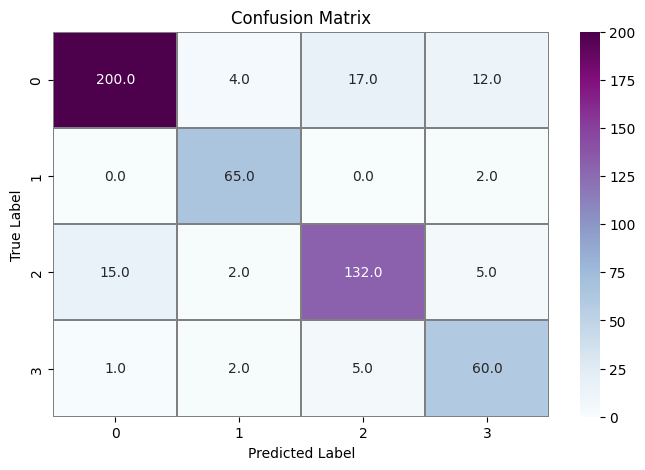

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.86      0.89       233
           1       0.89      0.97      0.93        67
           2       0.86      0.86      0.86       154
           3       0.76      0.88      0.82        68

    accuracy                           0.88       522
   macro avg       0.86      0.89      0.87       522
weighted avg       0.88      0.88      0.88       522



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

Y_pred = model.predict(X_test_preprocessed)
Y_pred_classes = np.argmax(Y_pred,axis=1)
Y_true = np.argmax(y_test,axis=1)

report = classification_report(Y_true, Y_pred_classes)

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, cmap="BuPu", linecolor="gray", fmt='.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


# Print classification report
print("Classification Report:")
print(report)

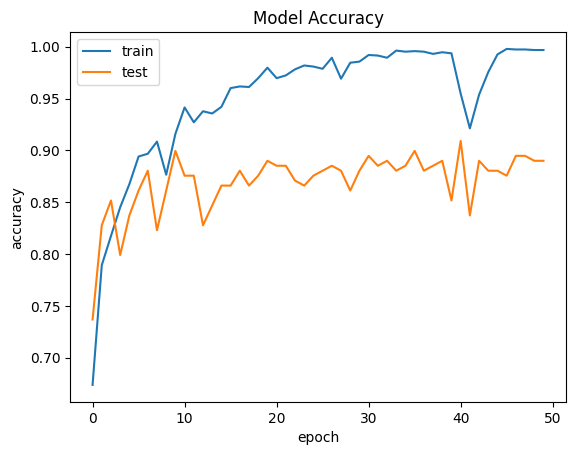

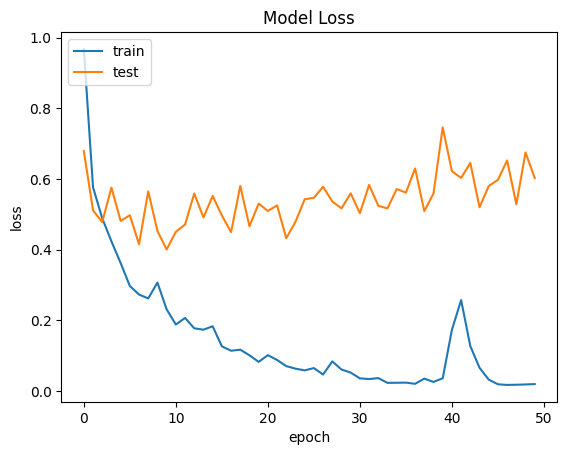

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()